# March 2024: Large Ensemble Ranges versus Observations

### Description:
We will be looking at the four largest ensembles, calculating their gradient trends and then seeing where observations lie within those ranges. Additionally, we will be quantifying where the observations lie within those ranges (i.e., ascertaining whether the models are struggling more to encompass these trends with time

### Structure:
Initial part of the code will be for selecting and running the models; output in the form of gradients and trends will be saved to a directory  
Second part of the code will read in observational data  
Third part of the code will read back in the model trend data and compare it with observations, including plotting  
Fourth part will calcluate MME mean for the models and also plot this

### Notes:  
I am not fixing the scenario historical matching here as it appears that's fine for the four model subset

In [133]:
%reset -f

In [134]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
%reload_ext autoreload
%autoreload 2

In [145]:
# analysis functions
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# systems functions
import os
from collections import defaultdict

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient, Gradient
from GradientProjectFunctions import CropTrendsDf, RemoveClimatology, DictToDf, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange, ClassifyModels
from GradientProjectFunctions import CalculateModelRange, CalculateObsPercentile, CreateScenarioDictionary, ExtendPeriod, ConcatModels, ClassifyHistModelsLite

## 1) Calculating model trends

In [146]:
# inputting from a csv file
directory = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

# inputting the historical data
fileName = 'cmip6_historical_opendap.csv'
os.chdir(directory)
inputHist = pd.read_csv(fileName)

# inputting the scenario data
fileName = 'cmip6_ScenarioMIP_opendap.csv'
inputScenario = pd.read_csv(fileName)

# selecting the models
models = ['MIROC-ES2L', 'ACCESS-ESM1-5', 'CNRM-CM6-1', 'EC-Earth3']

# filtering for the subset of links we are interested in
# first filtering the Scenario datasets because these are more limited
scenarioFilt = inputScenario[(inputScenario['experiment_id'] == 'ssp245') &
                             (inputScenario['variable_id'] == 'ts') &
                             ((inputScenario['grid_label'] == 'gn') |
                             (inputScenario['grid_label'] == 'gr'))
                            ]

# filtering the historical datasets based on which also have scenarios
histFilt = inputHist[inputHist['source_id'].isin(models) &
                     (inputHist['variable_id'] == 'ts') & 
                     ((inputHist['grid_label'] == 'gn') |
                     (inputHist['grid_label'] == 'gr'))
                    ]

# then refiltering the filtered scenario list based on the historical list in case there were some scenario ones that don't have historical runs (unlikely)
scenarioFilt = scenarioFilt[scenarioFilt['source_id'].isin(histFilt['source_id'])]

# saving all of the urls into one list
modelListHist = histFilt['URL'].tolist()
modelListScenario = scenarioFilt['URL'].tolist()

In [147]:
# classifying the models
histModels = ClassifyHistModelsLite(modelListHist)

In [142]:
scenarioModels = CreateScenarioDictionary(modelListScenario)

Scenario dictionary complete: 1 / 1877
Scenario dictionary complete: 2 / 1877
Scenario dictionary complete: 3 / 1877
Scenario dictionary complete: 4 / 1877
Scenario dictionary complete: 5 / 1877
Scenario dictionary complete: 6 / 1877
Scenario dictionary complete: 7 / 1877
Scenario dictionary complete: 8 / 1877
Scenario dictionary complete: 9 / 1877
Scenario dictionary complete: 10 / 1877
Scenario dictionary complete: 11 / 1877
Scenario dictionary complete: 12 / 1877
Scenario dictionary complete: 13 / 1877
Scenario dictionary complete: 14 / 1877
Scenario dictionary complete: 15 / 1877
Scenario dictionary complete: 16 / 1877
Scenario dictionary complete: 17 / 1877
Scenario dictionary complete: 18 / 1877
Scenario dictionary complete: 19 / 1877
Scenario dictionary complete: 20 / 1877
Scenario dictionary complete: 21 / 1877
Scenario dictionary complete: 22 / 1877
Scenario dictionary complete: 23 / 1877
Scenario dictionary complete: 24 / 1877
Scenario dictionary complete: 25 / 1877
Scenario 

In [143]:
# calculating and storing the trends

# creating a dictionary to store all of the trends information and attributes:
trendsDict = {}
trendsDfDict = {}
gradDict = {}
counter = 0
modelCount = len(histModels.keys())

for key in histModels:
    
    if key == 'Full':
        for model in histModels[key]:
            # loading and checking the data
            modelInput = ModelInput(model)
            
            # extending the model period through adding in scenarios
            modelIdentifier = modelInput.ds.attrs['source_id'] + '_' + modelInput.ds.attrs['variant_label']
            modelFullPeriod = ExtendPeriod(modelIdentifier, modelInput, scenarioModels)
            
            # remove the climatology from the full dataset
            modelFullPeriod = RemoveClimatology(modelFullPeriod)

            # calculating the gradient and the trends; creating dict with all trends labelled with model name
            gradient = Gradient(modelFullPeriod)
            gradDict[gradient.modelName] = gradient.gradient
            trendsDict[gradient.modelName] = Trend(gradient).trends
            trendsDfDict[gradient.modelName] = Trend(gradient).trendsDf
    
    else:
        # concatenating to the length of the initial period
        model = ConcatModels(histModels[key])
        
        # loading and checking the data
        modelInput = ModelInput(model)
        
        # extending the model period through adding in scenarios
        modelFullPeriod = ExtendPeriod(key, modelInput, scenarioModels)
        
        # remove the climatology from the full dataset
        modelFullPeriod = RemoveClimatology(modelFullPeriod)
        
        # calculating the gradient and the trends; creating dict with all trends labelled with model name
        gradient = Gradient(modelFullPeriod)
        gradDict[gradient.modelName] = gradient.gradient
        trendsDict[gradient.modelName] = Trend(gradient).trends
        trendsDfDict[gradient.modelName] = Trend(gradient).trendsDf
    
    counter+=1
    print(f'{counter} / {modelCount}')

Random - Hist: CNRM-CM6-1 - r10i1p1f2 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r1i1p1f2/Amon/ts/gr/v20190219/ts_Amon_CNRM-CM6-1_ssp245_r1i1p1f2_gr_201501-210012.nc
Random - Hist: CNRM-CM6-1 - r11i1p1f2 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r5i1p1f2/Amon/ts/gr/v20190410/ts_Amon_CNRM-CM6-1_ssp245_r5i1p1f2_gr_201501-210012.nc
Random - Hist: CNRM-CM6-1 - r12i1p1f2 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r4i1p1f2/Amon/ts/gr/v20190410/ts_Amon_CNRM-CM6-1_ssp245_r4i1p1f2_gr_201501-210012.nc
Random - Hist: CNRM-CM6-1 - r13i1p1f2 and Scenario: http://mary.ldeo.columbia.edu:8080/opendap/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1/ssp245/r3i1p1f2/Amon/ts/gr/v20190410/ts_Amon_CNRM-CM6-1_ssp245_r3i1p1f2_gr_201501-210012.nc
Random - Hist: CNRM-CM6-1 - r14i1p1f2 and Scenario: http://mary.ldeo.columbia.edu:80

IndexError: Cannot choose from an empty sequence

In [ ]:
modelInput

In [ ]:
# saving out the model output for CanESM5 and IPSL

trendsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Trends_240312'
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients_240312'

# saving the trends
# note that this will be saving the dataframes with the trends saved in them
os.chdir(trendsDir)

for modelName, trends in trendsDfDict.items():
    fileName = modelName+'_trends.csv'
    trends.to_csv(fileName, index = True)
    
# saving the gradients

for modelName, gradients in gradDict.items():
    pathName = gradientsDir+'/'+modelName+'.nc'
    gradients.to_netcdf(pathName)

## 2) Reading in the observational data

In [5]:
obsDir = '/home/hbyrne/Research/QMDA_2023'
fileName = 'HadISST_sst 2.nc'
os.chdir(obsDir)

In [6]:
# running the classes on it
modelInput = ModelInput(fileName)

# have to roll the coordinates for Hadley
modelInput = modelInput.ds.assign_coords(lon = ((360 + (modelInput.ds.lon % 360)) % 360))
modelInput = modelInput.roll(lon = int(len(modelInput['lon']) / 2), roll_coords = True)

# remove climatology
modelInput = RemoveClimatology(modelInput)

# calculate the gradient
gradient = CalculateObsGradient(modelInput, 'HadleyISST')

# calculate the trend
trendsHad = Trend(gradient).trends
trendsHadDf = Trend(gradient).trendsDf

/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libtbb.so.2: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


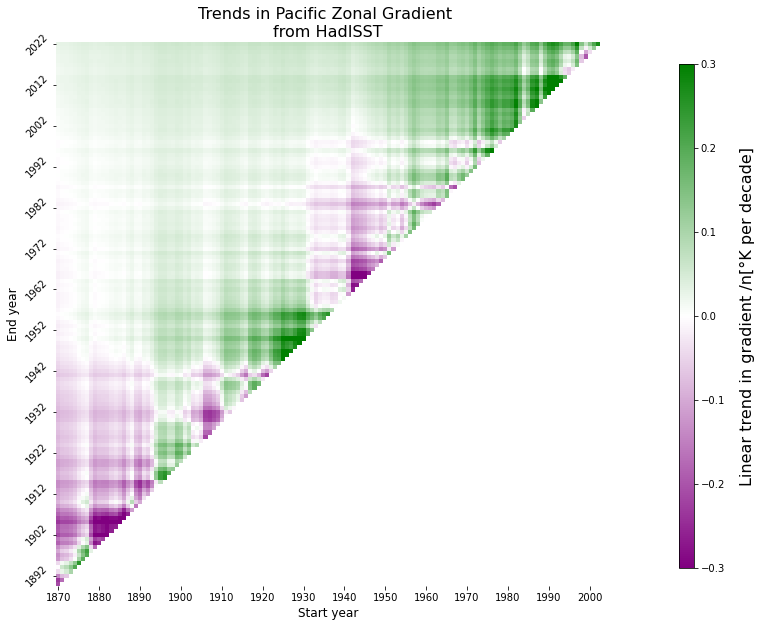

In [7]:
# the Had data has end dates that start at 1870 and start dates up to 2022; cropping so that we don't include those in the plot
# cropping the trends Df so that plotting doesn't include deadspace
offset = 20 # years
trendsHadDf = CropTrendsDf(trendsHadDf, offset)

# calculate the vmin and vmax
vmin = trendsHadDf.min().min()
vmax = trendsHadDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
vmin = -0.3
vmax = -vmin
    
# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

# plotting the figure
fig = plt.figure(figsize = (10,10))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsHadDf, 'Trends in Pacific Zonal Gradient \nfrom HadISST', vmin, vmax, cmap, norm)
ax = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([1, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear trend in gradient /n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

plt.show()

## 3) Read back in the trend data and calculate the 95% interval

Adding in functionality here, per Jason and Richard:  
Percentile where the observation lies  
Variance for each (maybe difference between 95% and 5%)

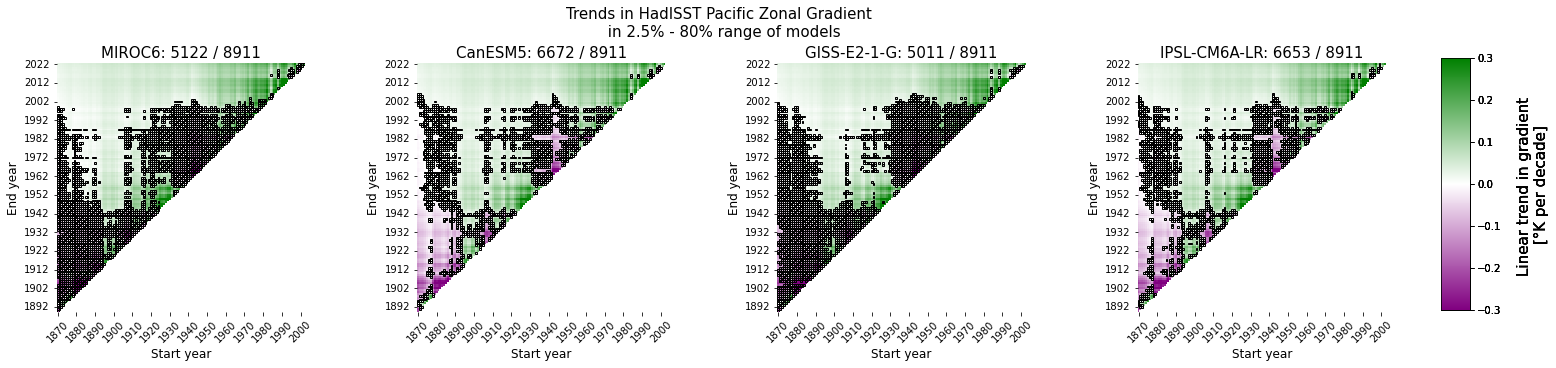

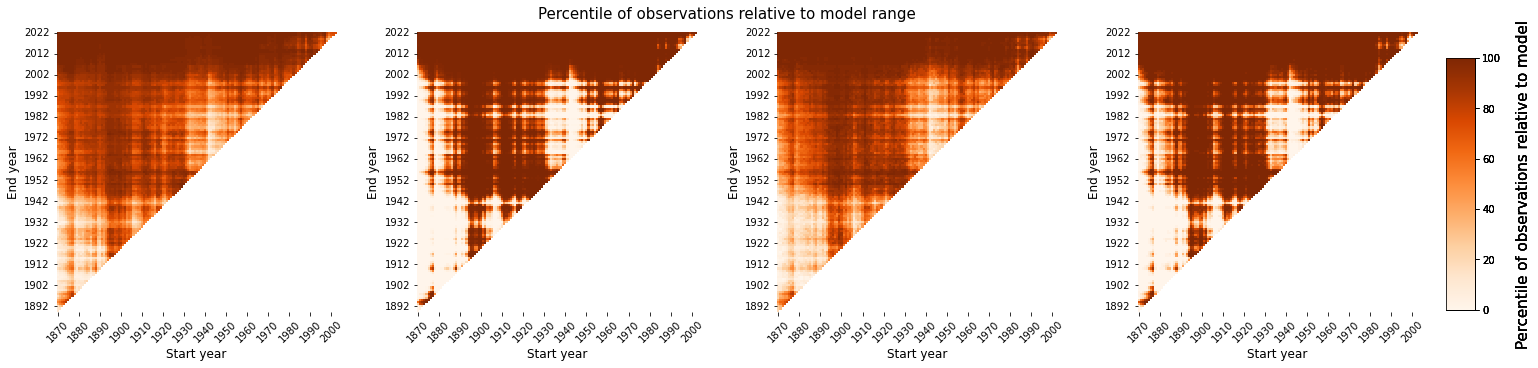

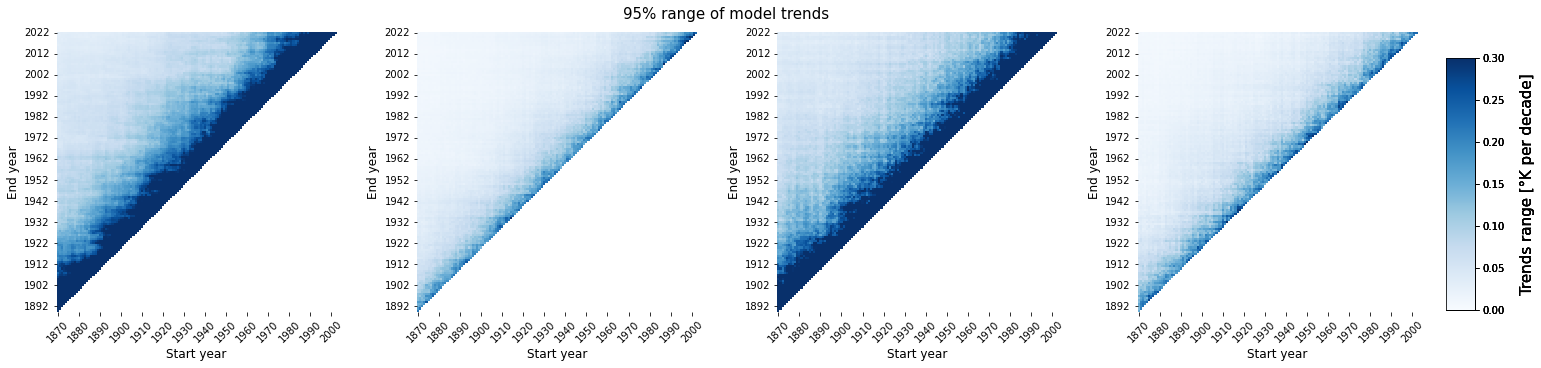

In [132]:
# trendsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Trends_240311'
os.chdir(trendsDir)

# model names so it can loop through and just select those models
# models = ['MIROC6', 'CanESM5', 'GISS-E2-1-G', 'IPSL-CM6A-LR']

# establishing some dictionaries to hold universal values (for now just universal 95% and 5% for all models)
dictLowerUni = defaultdict(list)
dictUpperUni = defaultdict(list)

# ___Plotting Figures____

# __Universal attributes___
nFigures = len(models)
nCols = 4

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (5, 5)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]


# ___Obs in Range____

# create the axes list
axesList = []

# create the figure
fig1 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig1.suptitle('Trends in HadISST Pacific Zonal Gradient \n in 95% range of models', fontsize = 15)

# ___Obs percentile___
fig2 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig2.suptitle('Percentile of observations relative to model range', fontsize = 15)

# __Model range___
fig3 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig3.suptitle('95% range of model trends', fontsize = 15)


for i, model in enumerate(models):
    
    # create a dictionary with all of the trends from this directory
    trendsDict = TrendsDictFromFiles(trendsDir, model)
    
    # create dictionaries with lower and upper percentiles from the distribution of trends
    dictLower, dictUpper = CalculateTrendPercentile(trendsDict, 2.5, 97.5)
    
    # saving these values to the universal dictionaries (entire dictionaries where each main key is the model name)
    dictLowerUni[model] = dictLower
    dictUpperUni[model] = dictUpper

    # flagging everywhere that the values lie within the range of the models
    dictObsInRange = FlagInRange(dictLower, dictUpper, trendsHad)
    
    # counting the number of grid points inside
    countOut = list(dictObsInRange.values()).count(0)
    countTotal = list(dictObsInRange.values()).count(1)+list(dictObsInRange.values()).count(0)

    # creating a dataframe for the ObsInRange
    dfObsInRange = DictToDf(dictObsInRange)

    # removing the bottom 20 rows so that this stippling df has the same dimensions as the observations
    keepRows = [row for row in dfObsInRange.index if row >= 1890]
    dfObsInRange = dfObsInRange.loc[keepRows, :]
    
    # calculating obs percentile
    dfObsPercentile = CalculateObsPercentile(trendsDict, trendsHad)
    
    # calculating total range
    dfRange = CalculateModelRange(dictLower, dictUpper)
    
    # plotting
    
    #___OBS IN RANGE___

    # calculate the vmin and vmax
    vmin = trendsHadDf.min().min()
    vmax = trendsHadDf.max().max()

    # find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
    if (vmin < 0) & (vmax > 0):
        limit = max(abs(vmin), abs(vmax))
        vmin = -limit
        vmax = limit

    vmin = -0.3
    vmax = -vmin

    # setting the colorbar
    colors = [(0,'purple'), (0.50,'white'), (1,'green')]
    cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig1.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')
    ax.set_title(f'{model}: {countOut} / {countTotal}', fontsize = 15)
    plot = sns.heatmap(trendsHadDf, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig1.add_axes([1, 0.15, 0.02, 0.7])
    colorBar = fig1.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Linear trend in gradient \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 15)

    # adding the stippling with a for loop
    for a, row in enumerate(dfObsInRange.values):
        for b, value in enumerate(row):
            if value == 1:
                plot.add_patch(plt.Rectangle((b, a), 1, 1, fill=False, edgecolor='black', hatch='////'))
                
    #___OBS PERCENTILE___
    # set max and min though they will always be the same
    vmin = 0
    vmax = 100

    # setting the colorbar
    cmap = 'Oranges'
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig2.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')
    #ax.set_title(f'{model}', fontsize = 15)
    plot = sns.heatmap(dfObsPercentile, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig2.add_axes([1, 0.15, 0.02, 0.7])
    colorBar = fig2.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Percentile of observations relative to model', rotation = 90, labelpad = 15, fontsize = 15)
    
    #___OBS RANGE___
    
    vmin = 0
    vmax = 0.3 # Note that these values were selected after running it once and looking at the max and min of the whole spread; have to be changed manually
    
    # setting the colorbar
    cmap = 'Blues'
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig3.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')    
    #ax.set_title(f'{model}', fontsize = 15)
    plot = sns.heatmap(dfRange, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig3.add_axes([1, 0.15, 0.02, 0.7])
    colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Trends range [°K per decade]', rotation = 90, labelpad = 15, fontsize = 15)
    

plt.show()

## 4) Calculating the mean

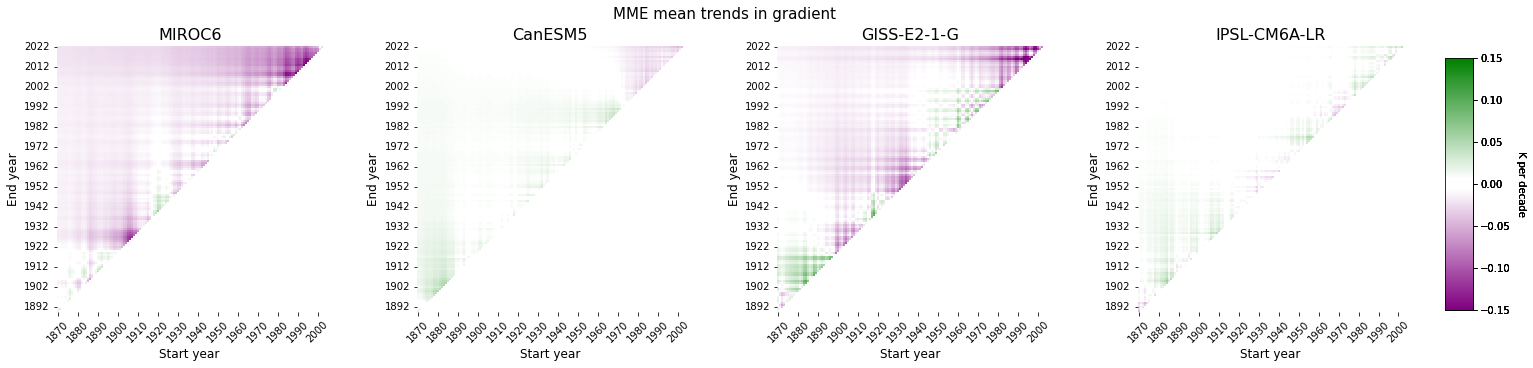

In [115]:
# gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients_240311'

# doing this for each of the models

# creating a dictionary to hold the trends to get max and min for plotting
dictTrends = defaultdict(list)

# __Universal attributes___
nFigures = len(models)
nCols = 4

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (5, 5)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]


# ___Obs in Range____

# create the axes list
axesList = []

# create the figure
fig4 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig4.suptitle('MME mean trends in gradient', fontsize = 15)

# running the loop through the models
for i, model in enumerate(models):
    gradientMean = CalculateMMEGradient(gradientsDir, model)
    trends = Trend(gradientMean).trends
    trendsDf = Trend(gradientMean).trendsDf
    
    # saving the trends to the dictionary
    dictTrends[model] = trends
    
    # cropping the trends Df so that plotting doesn't include deadspace
    offset = 20 # years
    trendsDfCrop = CropTrendsDf(trendsDf, offset)

    # calculate the vmin and vmax
    vmin = -0.15 # note that these were set manually after this had run once and the vmin and max had been determined
    vmax = -vmin

    # setting the colorbar
    colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
    cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig4.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')  
    trendPlotter = TrendPlotting(trendsDfCrop, model, vmin, vmax, cmap, norm)
    plot = trendPlotter.PlotTrends(ax)  
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)
    axesList.append(ax)

    cbarAx = fig4.add_axes([1, 0.15, 0.02, 0.7])
    colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('K per decade', rotation = 270, labelpad = 15)

In [126]:
# calculating the number of grid points that fall outside the model range
list(dictObsInRange.values()).count(np.nan)

14498

In [127]:
list(dictObsInRange.values()).count(0)+list(dictObsInRange.values()).count(1)

8911